In [1]:
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import spacy
from collections import Counter
from itertools import combinations
import itertools
from datetime import datetime
import networkx as nx
from wordcloud import WordCloud
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import pyLDAvis
import pyLDAvis.lda_model
import re

# limpieza de datos 

In [2]:
df = pd.read_csv("referencias_unificado.csv",delimiter='|')

In [3]:
print(df.shape)


(1367, 24)


In [4]:
df.head(3)


fuente                                     authors  \
0  scopus                                         NaN   
1  scopus                  Adline Freeda R.; Sudha K.   
2  scopus  Karlsson A.; Lindmaa E.; Sun S.; Staron M.   

                                   author_full_names  \
0                                                NaN   
1  Adline Freeda, R. (57191618601); Sudha, K. (59...   
2  Karlsson, Albin (59233098900); Lindmaa, Erik (...   

                                           Author_ID  \
0                                                NaN   
1                           57191618601; 59978506500   
2  59233098900; 59461382000; 59398905000; 6505767603   

                                               title  year  \
0  Future of Information and Communication Confer...  2025   
1  Top AI-powered tools for software test automation  2025   
2  AI-Based Automotive Test Case Generation: An A...  2025   

                                        source_title      volume issue  art  \
0              Lecture Notes in Networks and Systems   1283 LNNS   NaN  NaN   
1  Artificial Intelligence for Cloud-Native Softw...         NaN   NaN  NaN   
2  Lecture Notes in Computer Science (including s...  15453 LNCS   NaN  NaN   

   ...                              DOI  \
0  ...                              NaN   
1  ...  10.4018/979-8-3693-9356-7.ch010   
2  ...      10.1007/978-3-031-78392-0_4   

                                                link  \
0  https://www.scopus.com/inward/record.uri?eid=2...   
1  https://www.scopus.com/inward/record.uri?eid=2...   
2  https://www.scopus.com/inward/record.uri?eid=2...   

                                            abstract  \
0  The proceedings contain 138 papers. The specia...   
1  As software systems become more complex, there...   
2  Generative AI is transforming software develop...   

                                     author_Keywords  \
0                                                NaN   
1                                                NaN   
2  Generative AI; Hardware-in-the-Loop (HIL) Test...   

                                      index_keywords      document_type  \
0                                                NaN  Conference review   
1  Automation; Computer software selection and ev...       Book chapter   
2  Automatic test pattern generation; Automobile ...   Conference paper   

  publication_stage open_access  source                  EID  
0             Final         NaN  Scopus  2-s2.0-105000643403  
1             Final         NaN  Scopus  2-s2.0-105009879839  
2             Final         NaN  Scopus   2-s2.0-85211222986  

[3 rows x 24 columns]

In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1367 entries, 0 to 1366
Data columns (total 24 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fuente             1367 non-null   object 
 1   authors            1241 non-null   object 
 2   author_full_names  808 non-null    object 
 3   Author_ID          808 non-null    object 
 4   title              1367 non-null   object 
 5   year               1367 non-null   int64  
 6   source_title       1179 non-null   object 
 7   volume             825 non-null    object 
 8   issue              463 non-null    object 
 9   art                315 non-null    object 
 10  page_start         756 non-null    object 
 11  page_end           752 non-null    object 
 12  page_count         704 non-null    object 
 13  cited_by           895 non-null    float64
 14  DOI                1101 non-null   object 
 15  link               985 non-null    object 
 16  abstract           1303 

In [6]:
# Revisión de valores nulos
print(df.isnull().sum())

fuente                  0
authors               126
author_full_names     559
Author_ID             559
title                   0
year                    0
source_title          188
volume                542
issue                 904
art                  1052
page_start            611
page_end              615
page_count            663
cited_by              472
DOI                   266
link                  382
abstract               64
author_Keywords       571
index_keywords        656
document_type          90
publication_stage     472
open_access          1144
source                472
EID                   472
dtype: int64


In [7]:
# normalizar texto 
#Unificar formato para títulos, resúmenes y keywords:
#Pasar a minúsculas para análisis
#Eliminar espacios extra
#Quitar caracteres especiales innecesarios
cols_texto = ["title", "abstract", "author_Keywords", "index_keywords"]

for col in cols_texto:
    df[col] = df[col].astype(str).str.lower().str.strip()
    df[col] = df[col].str.replace(r"\s+", " ", regex=True)

In [8]:
#Convertir year a entero

#Asegurar que cited_by sea numérico

#Rellenar valores nulos con 0 si aplica
df["year"] = pd.to_numeric(df["year"], errors="coerce").fillna(0).astype(int)
df["cited_by"] = pd.to_numeric(df["cited_by"], errors="coerce").fillna(0).astype(int)

In [9]:
#Unificar keywords
#Separar por ; o ,

#Quitar duplicados internos

#Esto facilitará análisis de frecuencia de términos después
def limpiar_keywords(kw):
    if pd.isna(kw):
        return []
    partes = [k.strip() for k in kw.replace(";", ",").split(",")]
    return sorted(set(partes))

df["keywords_list"] = df["author_Keywords"].apply(limpiar_keywords)

In [10]:
# 3. Rellenar valores nulos en columnas de texto clave para evitar errores
df['abstract'] = df['abstract'].fillna('')
df['authors'] = df['authors'].fillna('')
df['DOI'] = df['DOI'].fillna('')
df['author_Keywords'] = df['author_Keywords'].fillna('')
df['index_keywords'] = df['index_keywords'].fillna('')

# Analisis descriptivo y bibliometrico

In [11]:
# validaciones 
sns.set(style="whitegrid", rc={"figure.dpi":150})

# Asegurar columnas mínimas (si faltan, crearlas vacías para evitar errores)
for c in ["fuente","authors","author_full_names","title","year","source_title","cited_by",
          "DOI","abstract","author_Keywords","index_keywords","document_type","open_access"]:
    if c not in df.columns:
        df[c] = np.nan

# info rápida
print("Registros:", df.shape[0])

Registros: 1367


In [12]:
df[["title","year","source_title"]].head(5)

title  year  \
0  future of information and communication confer...  2025   
1  top ai-powered tools for software test automation  2025   
2  ai-based automotive test case generation: an a...  2025   
3  exploration of experimental teaching mode of s...  2025   
4  the qualitative factor in software testing: a ...  2025   

                                        source_title  
0              Lecture Notes in Networks and Systems  
1  Artificial Intelligence for Cloud-Native Softw...  
2  Lecture Notes in Computer Science (including s...  
3                   Discover Artificial Intelligence  
4                    Journal of Systems and Software

In [13]:
print(df.isnull().sum().sort_values(ascending=False).head(20))

open_access          1144
art                  1052
issue                 904
page_count            663
page_end              615
page_start            611
Author_ID             559
author_full_names     559
volume                542
EID                   472
source                472
publication_stage     472
link                  382
source_title          188
document_type          90
author_Keywords         0
index_keywords          0
fuente                  0
abstract                0
DOI                     0
dtype: int64


In [14]:
# calidad de metadatos
# Un resumen rápido
print(df.describe(include='all').T[['count','unique']].head(30))

                    count unique
fuente               1367      4
authors              1367   1214
author_full_names     808    789
Author_ID             808    788
title                1367   1334
year               1367.0    NaN
source_title         1179    599
volume                825    317
issue                 463     32
art                   315    296
page_start            756    543
page_end              752    553
page_count            704    174
cited_by           1367.0    NaN
DOI                  1367   1102
link                  985    985
abstract             1367   1293
author_Keywords      1367    788
index_keywords       1367    712
document_type        1277     17
publication_stage     895      2
open_access           223      8
source                895      1
EID                   895    895
keywords_list        1367    780


In [15]:
# % de registros con DOI/abstract/keywords
for col in ["DOI","abstract","author_Keywords","author_full_names"]:
    pct = df[col].notna().sum()/len(df)*100
    print(f"{col}: {df[col].notna().sum()} ({pct:.1f}%)")

DOI: 1367 (100.0%)
abstract: 1367 (100.0%)
author_Keywords: 1367 (100.0%)
author_full_names: 808 (59.1%)


/home/cristian/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/cristian/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(
/home/cristian/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:77: DeprecationWarning: backend2gui is deprecated since IPython 8.24, backends are managed in matplotlib and can be externally registered.
  warnings.warn(


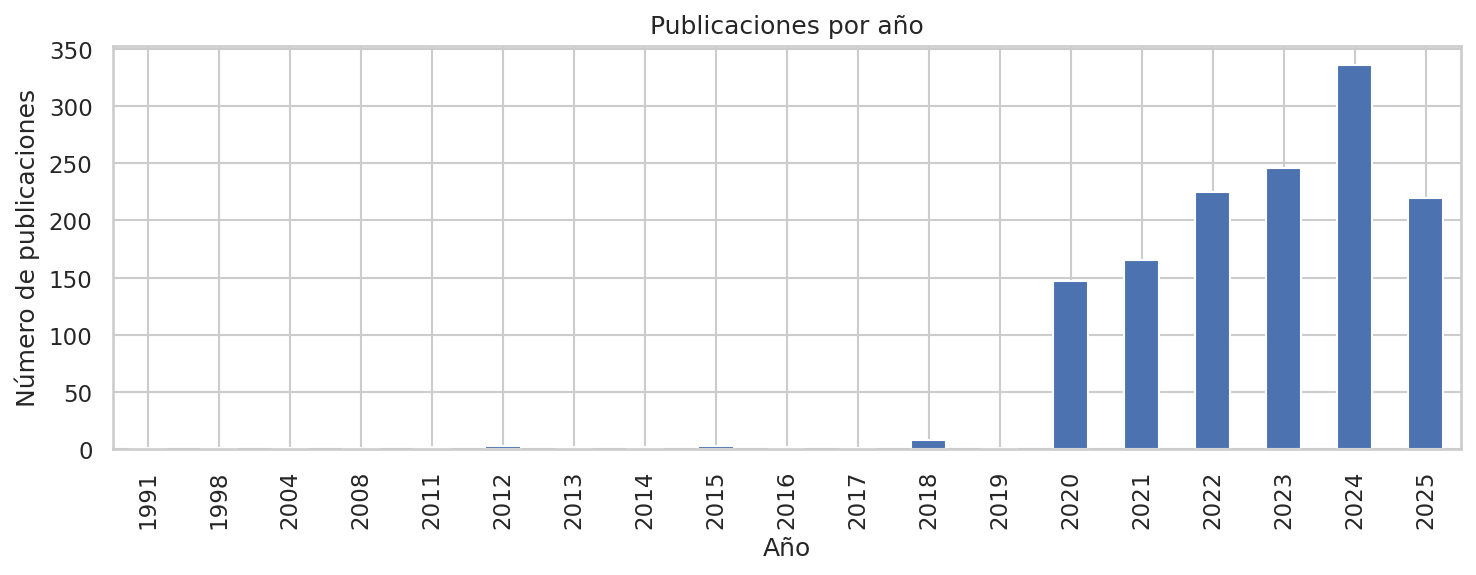

In [16]:
#publicaciones por año 
# Asegurar year numérico
df["year"] = pd.to_numeric(df["year"], errors="coerce").astype(pd.Int64Dtype())
pub_by_year = df.dropna(subset=["year"]).groupby("year").size().sort_index()

# Gráfica
plt.figure(figsize=(10,4))
pub_by_year.plot(kind="bar")
plt.title("Publicaciones por año")
plt.xlabel("Año"); plt.ylabel("Número de publicaciones")
plt.tight_layout()
plt.show()
#$plt.savefig("pub_by_year.png")
#$plt.close()

# crecimiento porcentual año a año
pct_change = pub_by_year.pct_change().fillna(0) * 100
pct_change.to_csv("pub_by_year_pct_change.csv")

In [17]:
#fuente
# Preferir 'source_title' si está, sino 'fuente'
src_col = "source_title" if "source_title" in df.columns else "fuente"
top_sources = df[src_col].fillna("Unknown").value_counts().head(30)
top_sources.to_csv("top_sources.csv")

# Índice de concentración (HHI: suma de cuadrados de shares, entre 0 y 1)
shares = df[src_col].value_counts(normalize=True)
hhi = (shares**2).sum()
print("HHI (0-1):", hhi)

HHI (0-1): 0.006469593342930173


In [18]:
# Autores
# Elegir columna con nombres completos si existe
auth_col = "author_full_names" if "author_full_names" in df.columns else "authors"

def split_authors(s):
    if pd.isna(s) or s=="":
        return []
    # Ajusta separadores según tu dataset; cuidado con "Last, First"
    parts = re.split(r";|\||, and | and |\,\s(?=[A-Z])", s)
    return [p.strip() for p in parts if p.strip()]

auth_lists = df[auth_col].fillna("").apply(split_authors)
all_auth = auth_lists.explode().value_counts().head(50)
all_auth.to_csv("top_authors.csv")

# Construir red de coautoría (en nodes se usan solo autores con >=1)
G = nx.Graph()
for authors in auth_lists:
    for i in range(len(authors)):
        for j in range(i+1, len(authors)):
            a,b = authors[i], authors[j]
            if G.has_edge(a,b):
                G[a][b]['weight'] += 1
            else:
                G.add_edge(a,b, weight=1)

# Métricas simples
deg = sorted(G.degree(weight='weight'), key=lambda x: x[1], reverse=True)[:30]
pd.DataFrame(deg, columns=["author","degree"]).to_csv("coauthor_degree_top30.csv")
print("Nodos coautoría:", G.number_of_nodes(), "Aristas:", G.number_of_edges())

Nodos coautoría: 4527 Aristas: 23323


/tmp/ipykernel_223214/1378204979.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='keyword', x='freq', data=kw_df, palette='viridis')


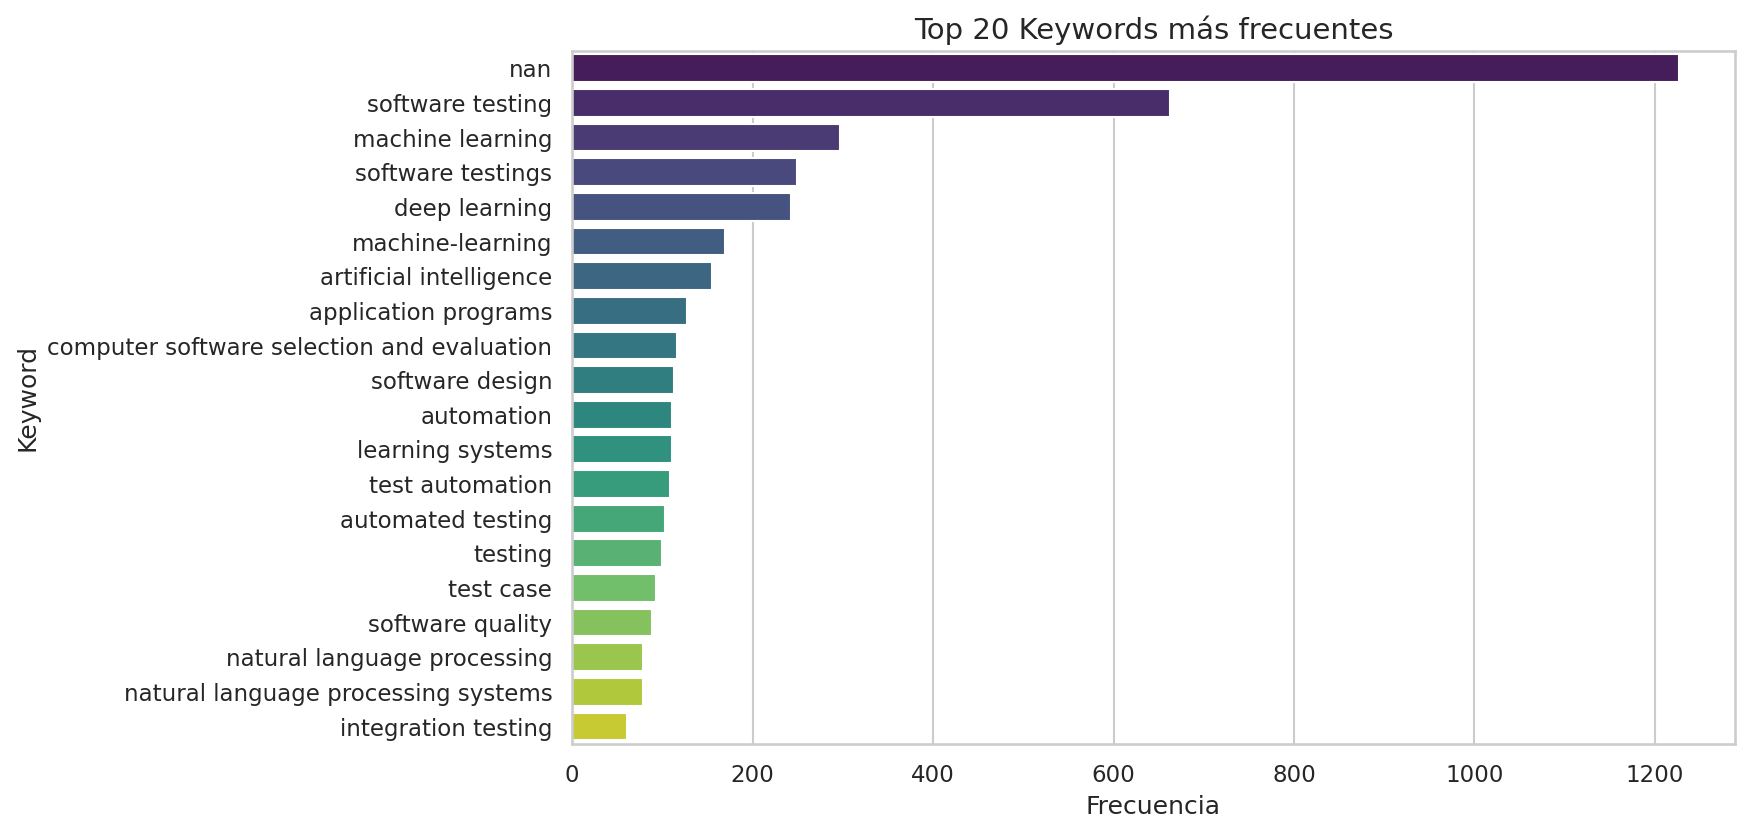

In [51]:
#Keywords — frecuencia y co-ocurrencia
# Unir keywords de ambas columnas si existen
keywords_series = (
    df['author_Keywords'].fillna('') + ';' + df['index_keywords'].fillna('')
)

# Dividir por separador y limpiar
keywords = []
for row in keywords_series:
    for kw in str(row).split(';'):
        kw_clean = kw.strip().lower()
        if kw_clean:
            keywords.append(kw_clean)

# Contar frecuencia
counter = Counter(keywords)
top_keywords = counter.most_common(20)

# DataFrame para gráfico
kw_df = pd.DataFrame(top_keywords, columns=['keyword', 'freq'])

# Visualizar
plt.figure(figsize=(10,6))
sns.barplot(y='keyword', x='freq', data=kw_df, palette='viridis')
plt.title("Top 20 Keywords más frecuentes", fontsize=14)
plt.xlabel("Frecuencia")
plt.ylabel("Keyword")
plt.show()

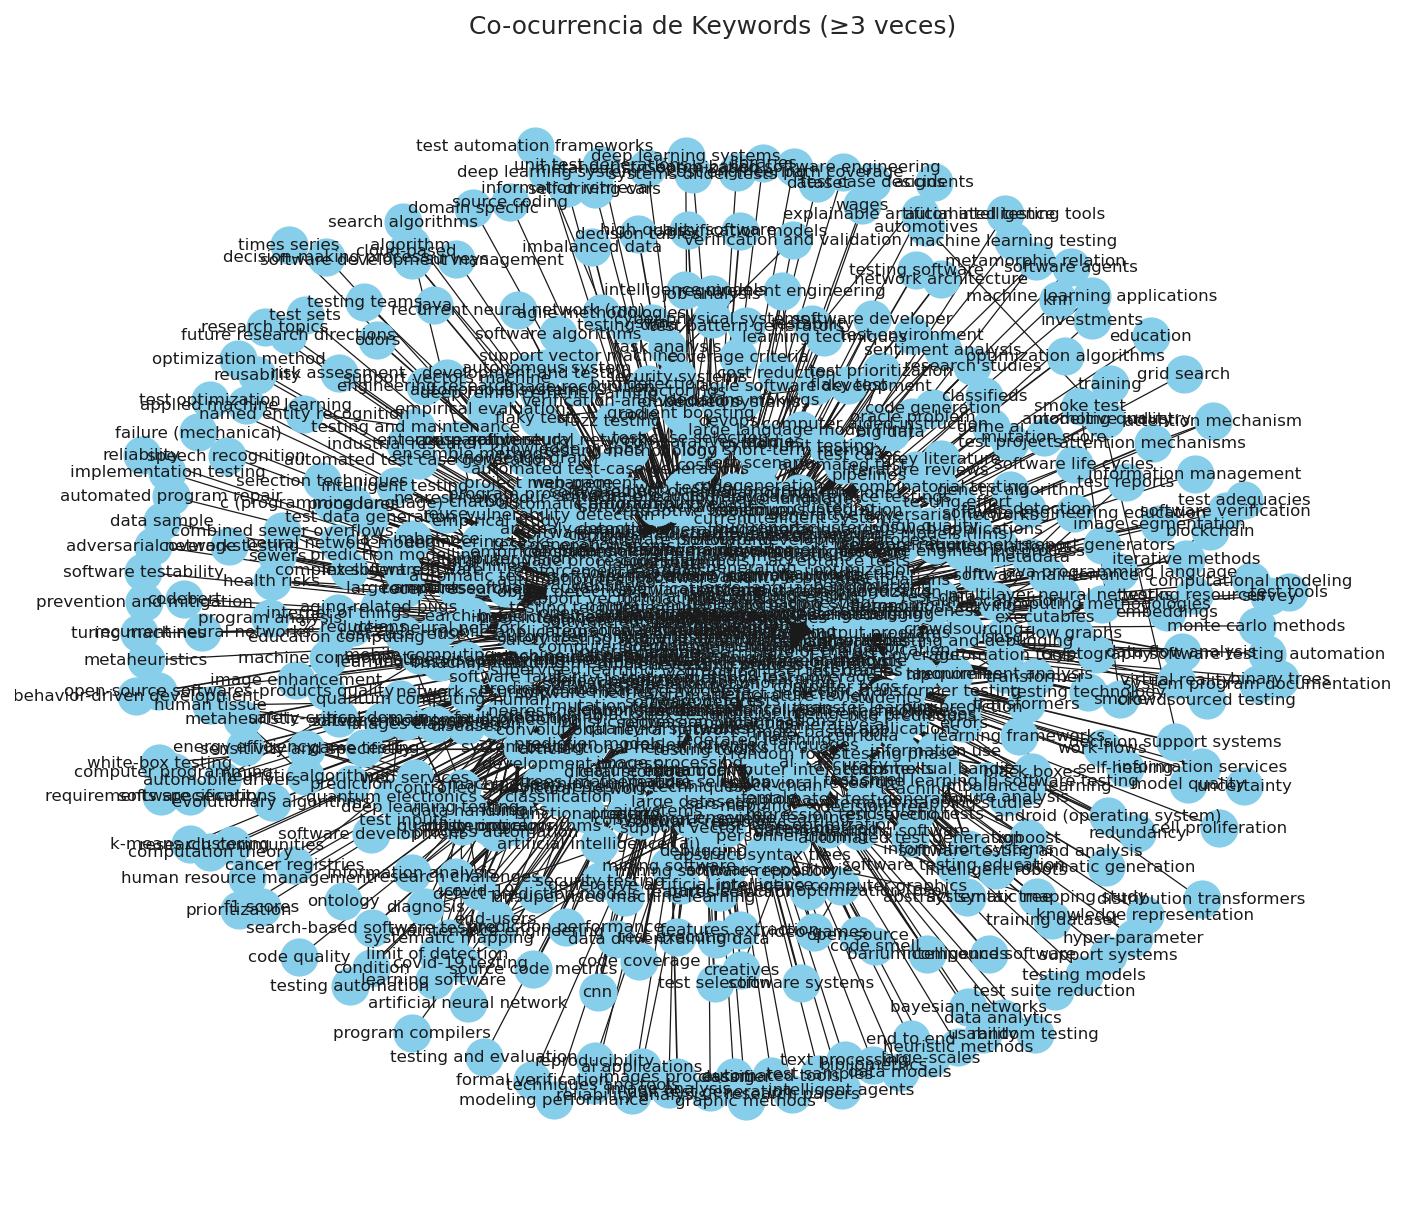

In [20]:
#Co-ocurrencia de Keywords
#Objetivo: detectar qué términos aparecen juntos con más frecuencia.
# Crear pares de co-ocurrencia
cooc_pairs = Counter()
for row in keywords_series:
    kws = list(set([kw.strip().lower() for kw in str(row).split(';') if kw.strip()]))
    for combo in combinations(kws, 2):
        cooc_pairs[tuple(sorted(combo))] += 1

# Grafo de co-ocurrencias
G = nx.Graph()
for (kw1, kw2), freq in cooc_pairs.items():
    if freq >= 3:  # filtro para no saturar
        G.add_edge(kw1, kw2, weight=freq)

# Dibujar grafo
plt.figure(figsize=(12, 10))
pos = nx.spring_layout(G, k=0.5)
nx.draw_networkx_nodes(G, pos, node_size=300, node_color='skyblue')
nx.draw_networkx_edges(G, pos, width=[G[u][v]['weight']*0.2 for u,v in G.edges()])
nx.draw_networkx_labels(G, pos, font_size=8)
plt.title("Co-ocurrencia de Keywords (≥3 veces)")
plt.axis('off')
plt.show()

/tmp/ipykernel_223214/1564415411.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')


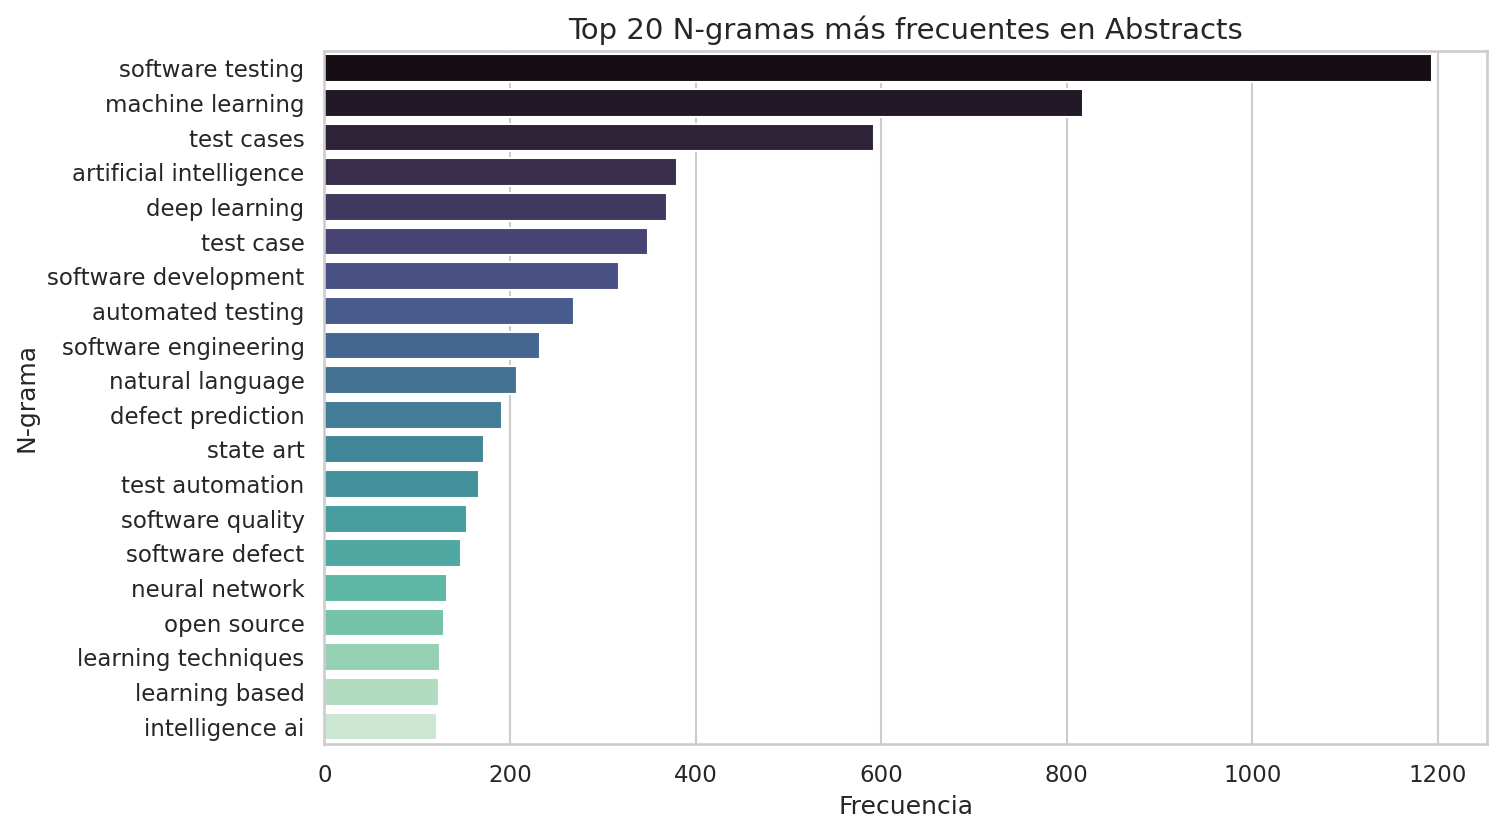

In [21]:
#N-gramas y términos en Abstracts
#Objetivo: encontrar frases comunes y términos recurrentes en los resúmenes.
# Unir todos los abstracts
abstracts = df['abstract'].fillna('').str.lower()

# N-gramas (2 y 3 palabras)
vectorizer = CountVectorizer(ngram_range=(2,3), stop_words='english').fit(abstracts)
X = vectorizer.transform(abstracts)
sum_words = X.sum(axis=0)

ngrams_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
ngrams_freq = sorted(ngrams_freq, key=lambda x: x[1], reverse=True)[:20]

# DataFrame
ngram_df = pd.DataFrame(ngrams_freq, columns=['ngram', 'freq'])

# Visualizar
plt.figure(figsize=(10,6))
sns.barplot(y='ngram', x='freq', data=ngram_df, palette='mako')
plt.title("Top 20 N-gramas más frecuentes en Abstracts", fontsize=14)
plt.xlabel("Frecuencia")
plt.ylabel("N-grama")
plt.show()

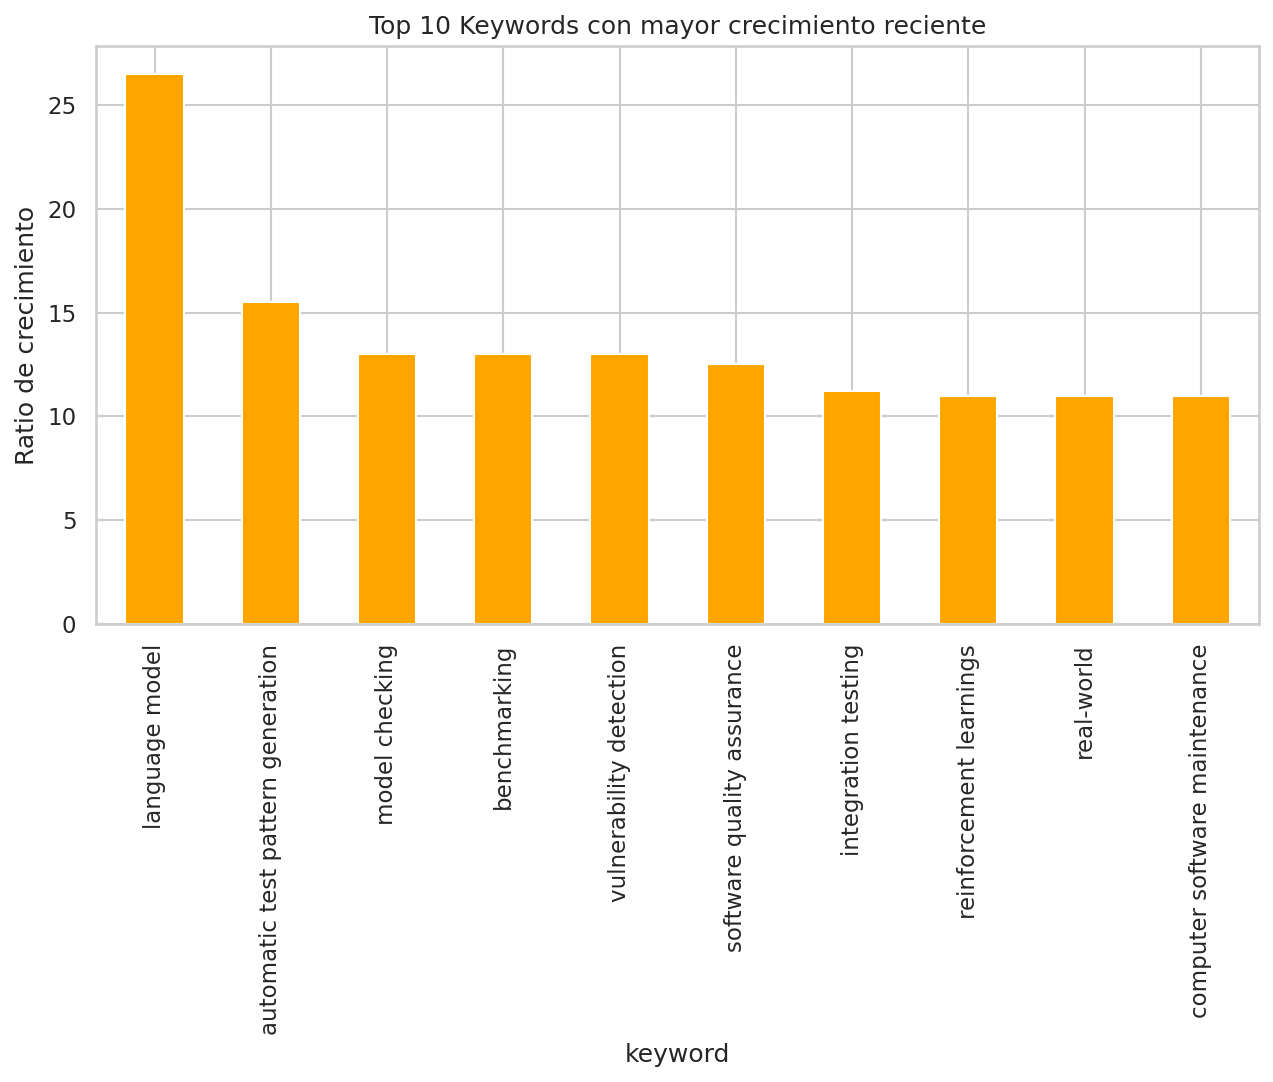

In [22]:
# Normalizamos año
df['year'] = pd.to_numeric(df['year'], errors='coerce')
df = df.dropna(subset=['year'])

# Expandir keywords con año
rows = []
for _, row in df.iterrows():
    kws = (str(row['author_Keywords']) + ';' + str(row['index_keywords'])).split(';')
    for kw in kws:
        kw_clean = kw.strip().lower()
        if kw_clean:
            rows.append({'year': int(row['year']), 'keyword': kw_clean})

kw_year_df = pd.DataFrame(rows)

# Contar frecuencia por año
trend = kw_year_df.groupby(['keyword', 'year']).size().reset_index(name='count')

# Calcular crecimiento relativo (últimos 3 años vs resto)
latest_years = trend['year'].max() - 2
growth = (
    trend[trend['year'] >= latest_years]
    .groupby('keyword')['count'].sum()
    / trend[trend['year'] < latest_years]
    .groupby('keyword')['count'].sum()
)

growth = growth.sort_values(ascending=False).dropna().head(10)

# Visualizar crecimiento
growth.plot(kind='bar', figsize=(10,5), color='orange')
plt.title("Top 10 Keywords con mayor crecimiento reciente")
plt.ylabel("Ratio de crecimiento")
plt.show()

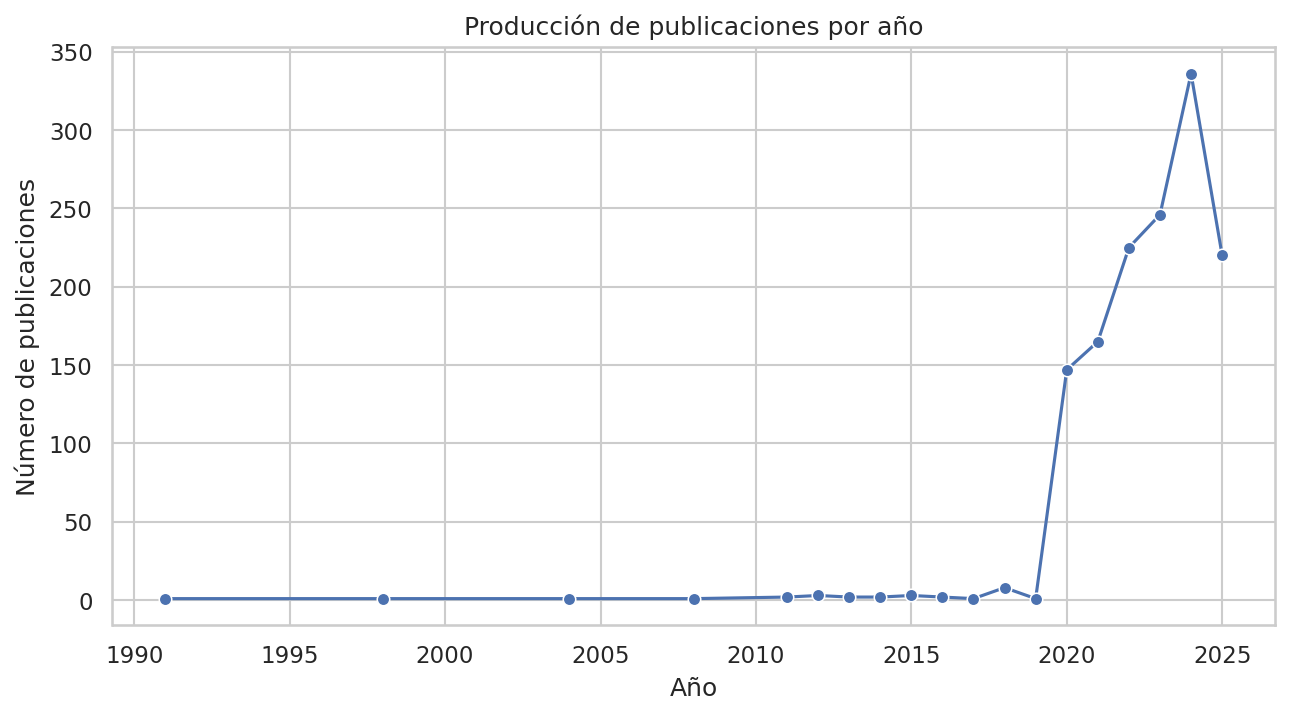

In [23]:
# ========================
# 1. Producción por año
# ========================
pub_per_year = df.groupby('year').size()

plt.figure(figsize=(10, 5))
sns.lineplot(x=pub_per_year.index, y=pub_per_year.values, marker='o')
plt.title("Producción de publicaciones por año")
plt.xlabel("Año")
plt.ylabel("Número de publicaciones")
plt.grid(True)
plt.show()

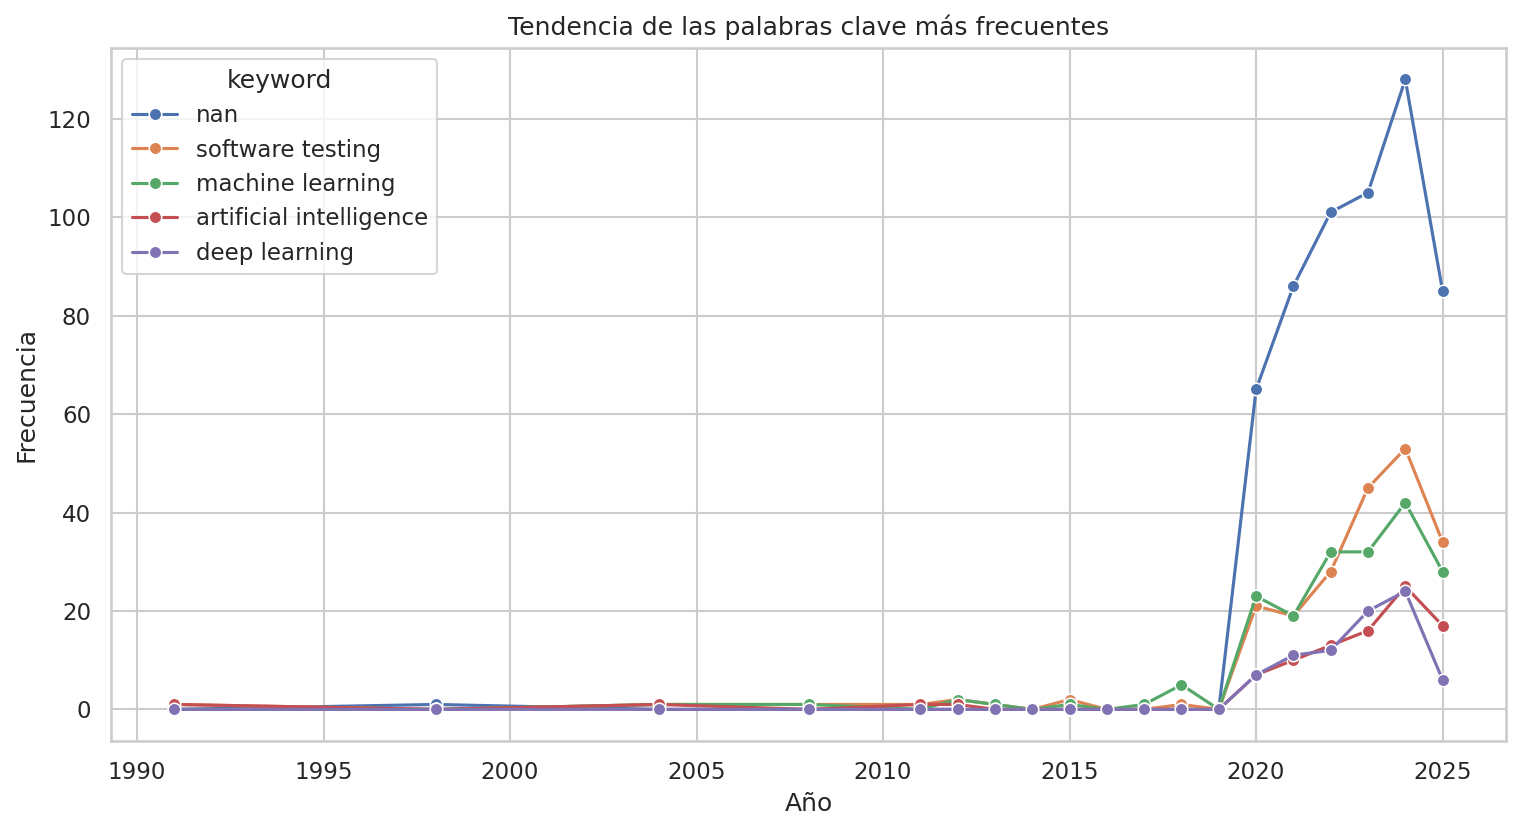

In [24]:
# ========================
# 2. Tendencias de palabras clave más frecuentes
# ========================

# Función para limpiar y separar palabras clave
def clean_keywords(text):
    if pd.isna(text):
        return []
    # Separar por ; o , y limpiar espacios
    words = re.split(r';|,', text)
    return [w.strip().lower() for w in words if w.strip()]

# Expandir keywords en filas
df_keywords = df[['year', 'author_Keywords']].dropna()
df_keywords['keywords_list'] = df_keywords['author_Keywords'].apply(clean_keywords)

all_keywords = [kw for kws in df_keywords['keywords_list'] for kw in kws]
top_keywords = [kw for kw, _ in Counter(all_keywords).most_common(5)]

# Crear DataFrame de tendencias
trend_data = []
for year, group in df_keywords.groupby('year'):
    kws_year = [kw for kws in group['keywords_list'] for kw in kws]
    counts = Counter(kws_year)
    for kw in top_keywords:
        trend_data.append({'year': year, 'keyword': kw, 'count': counts.get(kw, 0)})

trend_df = pd.DataFrame(trend_data)

plt.figure(figsize=(12, 6))
sns.lineplot(data=trend_df, x='year', y='count', hue='keyword', marker='o')
plt.title("Tendencia de las palabras clave más frecuentes")
plt.xlabel("Año")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

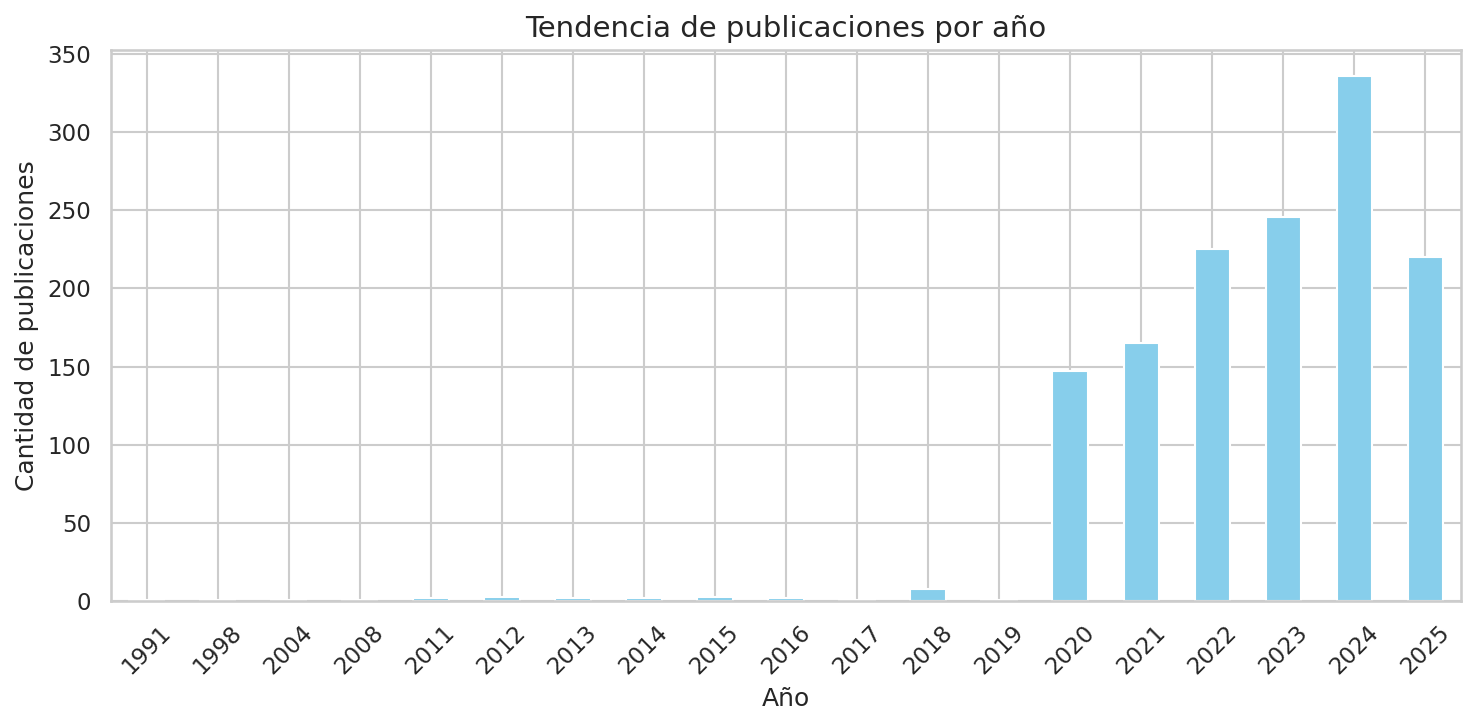

In [25]:
# Agrupar por año y contar
pubs_por_anio = df.groupby("year")["title"].count()

# Graficar
plt.figure(figsize=(10,5))
pubs_por_anio.plot(kind='bar', color='skyblue')
plt.title("Tendencia de publicaciones por año", fontsize=14)
plt.xlabel("Año")
plt.ylabel("Cantidad de publicaciones")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [26]:
# Crear grafo
G = nx.Graph()

for autores in df['authors'].dropna():
    lista_autores = [a.strip() for a in autores.split(";")]
    for i in range(len(lista_autores)):
        for j in range(i+1, len(lista_autores)):
            G.add_edge(lista_autores[i], lista_autores[j])

# Dibujar red (simplificada para autores con más de 3 artículos)
autores_frecuentes = [a for a, count in top_autores.items()]
H = G.subgraph(autores_frecuentes)

plt.figure(figsize=(8,8))
nx.draw(H, with_labels=True, node_size=500, node_color="lightblue", font_size=8)
plt.title("Red de coautoría (autores más prolíficos)", fontsize=14)
plt.show()

/home/cristian/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/home/cristian/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/home/cristian/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*args, **kwargs)
/home/cristian/anaconda3/lib/python3.12/site-packages/executing/executing.py:713: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  right=ast.Str(s=sentinel),
/home/cristian/anaconda3/lib/python3.12/ast.py:587: DeprecationWarning: Attribute s is deprecated and will be removed in Python 3.14; use value instead
  return Constant(*

NameError: name 'top_autores' is not defined

In [27]:
G = nx.Graph()

for autores in df['authors'].dropna():
    lista_autores = [a.strip() for a in autores.split(";")]
    for i in range(len(lista_autores)):
        for j in range(i+1, len(lista_autores)):
            if G.has_edge(lista_autores[i], lista_autores[j]):
                G[lista_autores[i]][lista_autores[j]]['weight'] += 1
            else:
                G.add_edge(lista_autores[i], lista_autores[j], weight=1)

In [28]:
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
eigenvector_centrality = nx.eigenvector_centrality(G)

# Top 5 autores por cada métrica
print("Top 5 por grado:", sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 por intermediación:", sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:5])
print("Top 5 por eigenvector:", sorted(eigenvector_centrality.items(), key=lambda x: x[1], reverse=True)[:5])

Top 5 por grado: [('Liu Y.', 0.015955903684363216), ('Zhang Y.', 0.013635044966637656), ('Li Y.', 0.011894400928343488), ('Li Z.', 0.010443864229765013), ('Wang J.', 0.010153756890049319)]
Top 5 por intermediación: [('Liu Y.', 0.003230096521768029), ('Wang J.', 0.0032154515994431273), ('Liu J.', 0.003088017256963397), ('Li Y.', 0.0030200037133899416), ('Zhang Y.', 0.0029949526363926052)]
Top 5 por eigenvector: [('Jiang, He', 0.1997359758665371), ('Li, Xiaochen', 0.1997359758665371), ('Xia, Xin', 0.19845655541267812), ('Zhou, Yuming', 0.19821798838081328), ('Chen, Xiangping', 0.19509358593584913)]


In [29]:
# Nos aseguramos de que las columnas necesarias existan
for col in ["title", "abstract", "author_Keywords", "year"]:
    if col not in df.columns:
        raise ValueError(f"Falta la columna '{col}' en el CSV.")

In [30]:
# ====== 2. Unir texto ======
df["all_text"] = (
    df["title"].fillna("") + " " +
    df["abstract"].fillna("") + " " +
    df["author_Keywords"].fillna("")
)

In [31]:
nltk.download('stopwords')
stop_words = set(stopwords.words('english') + stopwords.words('spanish'))

# ====== 3. Función de limpieza ======
def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r"[^a-záéíóúüñ\s]", "", text)  # letras y espacios
    tokens = [word for word in text.split() if word not in stop_words and len(word) > 2]
    return " ".join(tokens)

df["clean_text"] = df["all_text"].apply(limpiar_texto)

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [32]:
# ====== 4. Palabras más frecuentes ======
all_words = " ".join(df["clean_text"]).split()
word_freq = Counter(all_words)
common_words = word_freq.most_common(20)

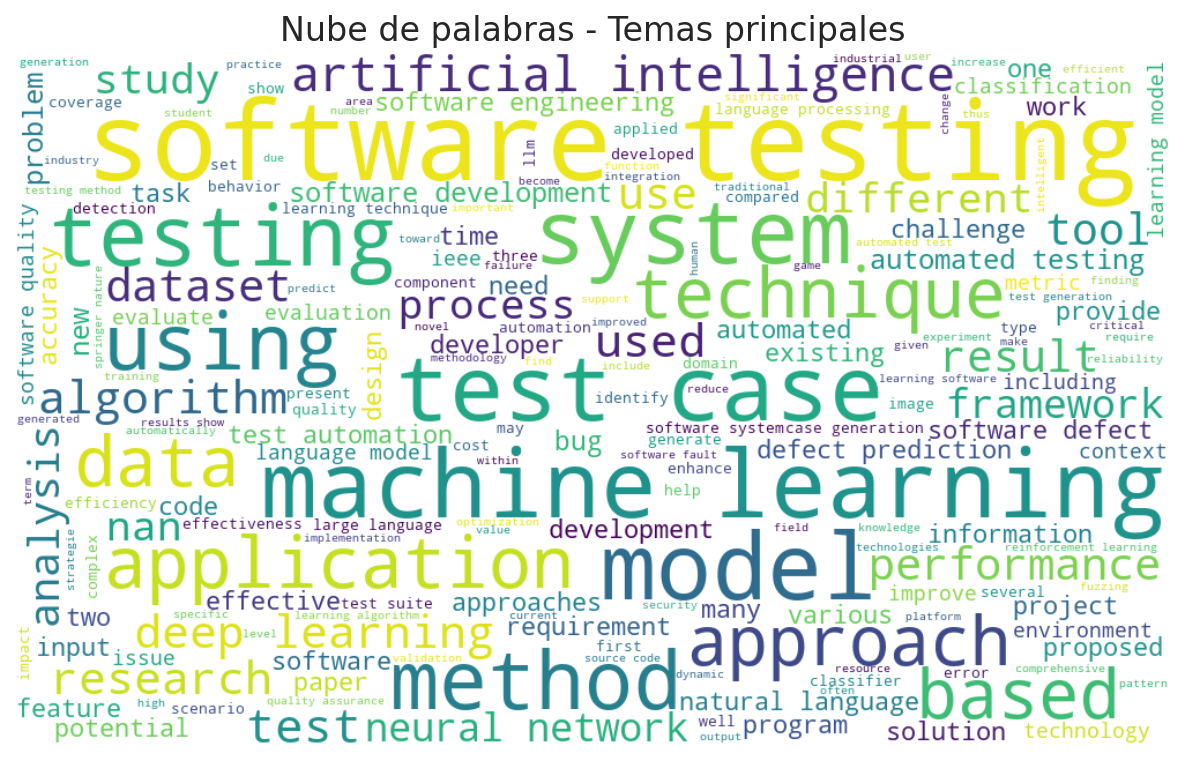

In [33]:
# ====== 5. Nube de palabras ======
wc = WordCloud(width=1000, height=600, background_color="white").generate(" ".join(all_words))
plt.figure(figsize=(10,6))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de palabras - Temas principales", fontsize=16)
plt.show()

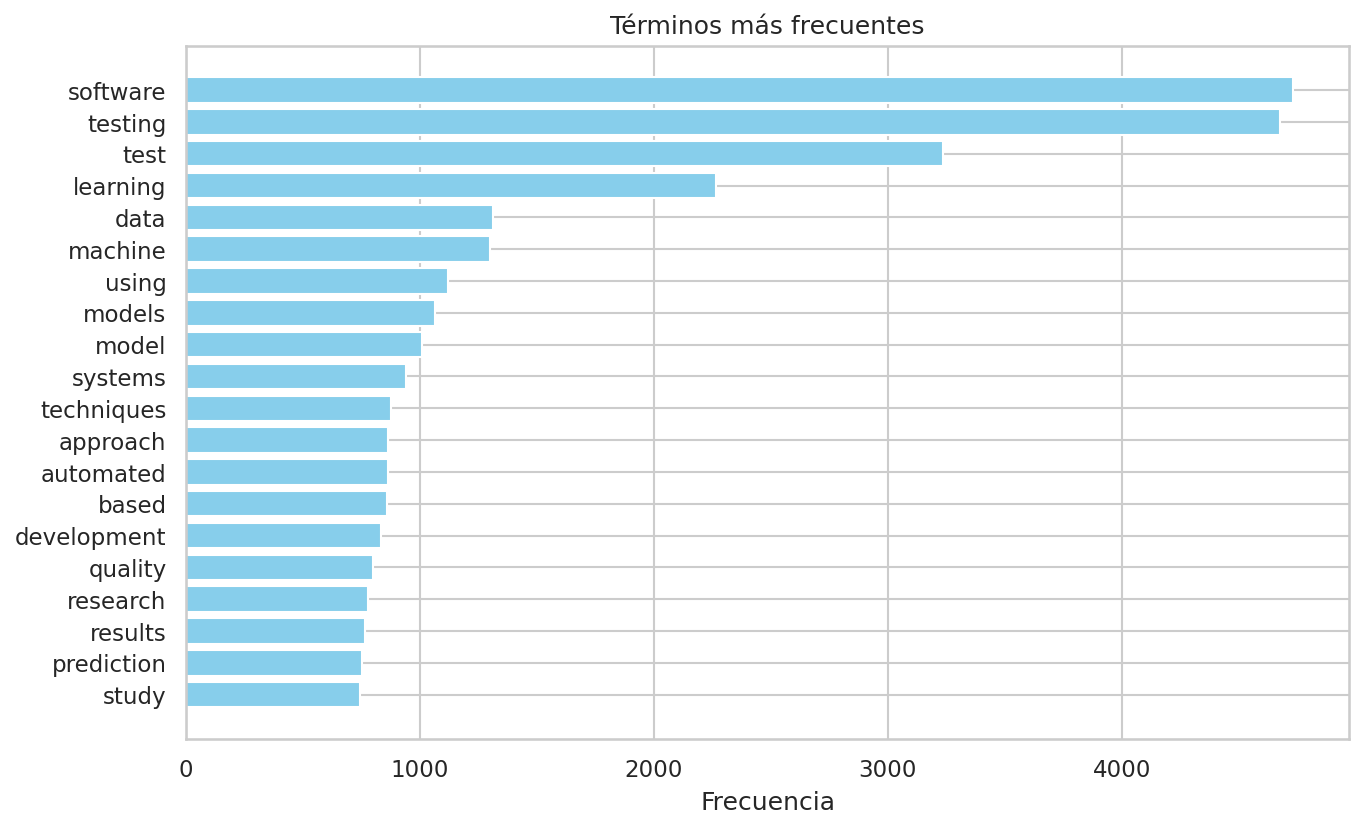

In [34]:
# ====== 6. Barra de términos más frecuentes ======
words, freqs = zip(*common_words)
plt.figure(figsize=(10,6))
plt.barh(words[::-1], freqs[::-1], color="skyblue")
plt.title("Términos más frecuentes")
plt.xlabel("Frecuencia")
plt.show()

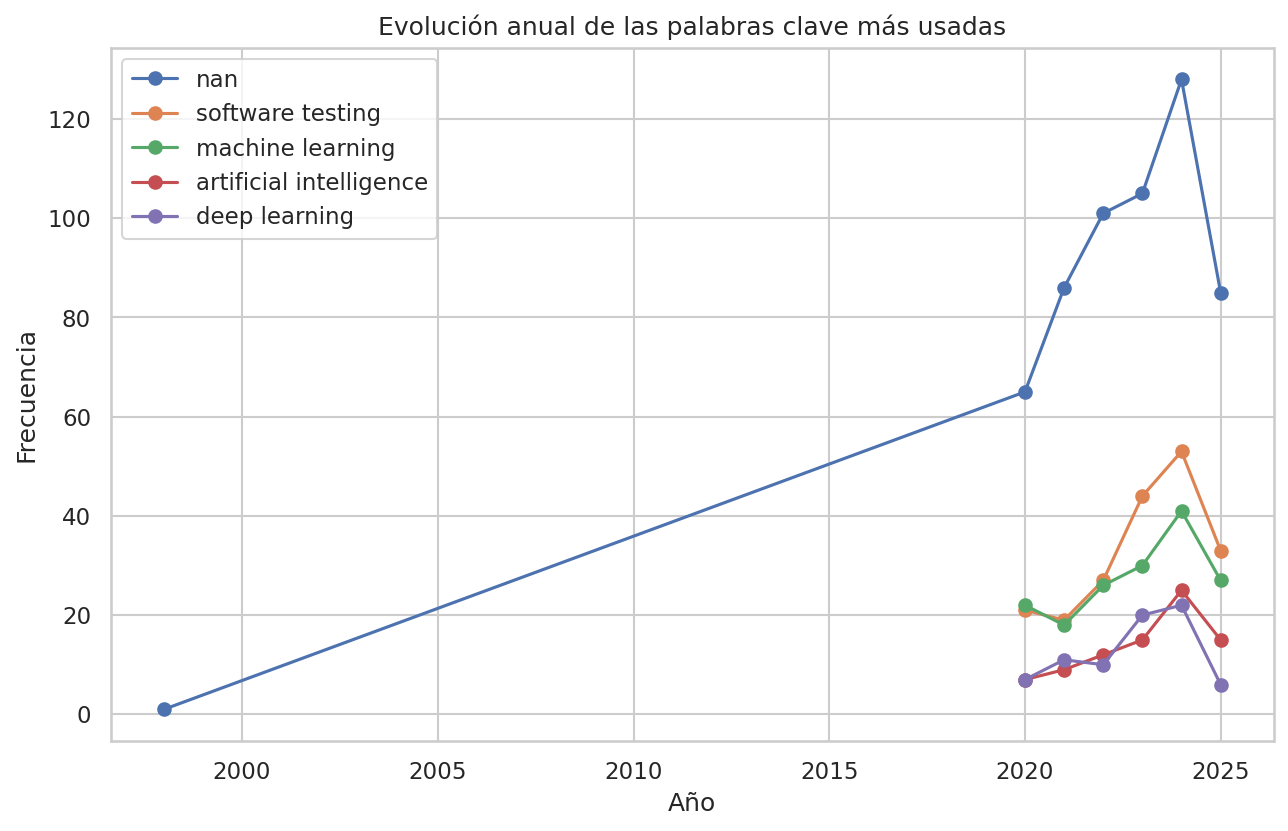

In [35]:
# ====== 8. Evolución anual de palabras clave ======
df["kw_list"] = df["author_Keywords"].fillna("").apply(lambda x: [k.strip().lower() for k in x.split(";") if k.strip()])
df["year"] = pd.to_numeric(df["year"], errors="coerce")
year_kw = {}
for _, row in df.iterrows():
    year = row["year"]
    for kw in row["kw_list"]:
        year_kw.setdefault(kw, {}).setdefault(year, 0)
        year_kw[kw][year] += 1

# Seleccionamos top 5 keywords por frecuencia total
total_kw = Counter({kw: sum(freqs.values()) for kw, freqs in year_kw.items()})
top_keywords = [kw for kw, _ in total_kw.most_common(5)]

plt.figure(figsize=(10,6))
for kw in top_keywords:
    years = sorted(year_kw[kw].keys())
    counts = [year_kw[kw][y] for y in years]
    plt.plot(years, counts, marker="o", label=kw)

plt.title("Evolución anual de las palabras clave más usadas")
plt.xlabel("Año")
plt.ylabel("Frecuencia")
plt.legend()
plt.show()

In [36]:
# Combinar columnas relevantes (evitar NaN)
df["text"] = df[["title", "abstract", "author_Keywords"]].fillna("").agg(" ".join, axis=1)

# --------------------
# 2. Limpieza y preprocesamiento
# --------------------
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])  # Usa modelo inglés
stopwords_extra = {"study", "results", "paper", "using", "based"}  # Palabras poco informativas

def limpiar_texto(text):
    text = text.lower()
    text = re.sub(r'[^a-záéíóúüñ ]', ' ', text)  # Solo letras y espacios
    doc = nlp(text)
    tokens = [tok.lemma_ for tok in doc 
              if tok.is_alpha and tok.lemma_ not in stopwords_extra and not tok.is_stop]
    return " ".join(tokens)

df["clean_text"] = df["text"].apply(limpiar_texto)

# --------------------
# 3. Vectorización
# --------------------
vectorizer = CountVectorizer(max_df=0.8, min_df=3)  
X = vectorizer.fit_transform(df["clean_text"])

# --------------------
# 4. Entrenar LDA
# --------------------
n_topics = 8  # Ajusta el número de temas
lda = LatentDirichletAllocation(n_components=n_topics, 
                                random_state=42,
                                learning_method="batch")
lda.fit(X)

# --------------------
# 5. Mostrar palabras por tema
# --------------------
def mostrar_temas(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]]
        print(f"Tema {topic_idx+1}: {' | '.join(top_words)}")

mostrar_temas(lda, vectorizer.get_feature_names_out(), 10)

# --------------------
# 6. Visualización pyLDAvis
# --------------------
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, X, vectorizer, mds='tsne')
pyLDAvis.save_html(panel, "LDA_resultados.html")

print("\n✅ Resultados guardados en 'LDA_resultados.html' para exploración interactiva.")

Tema 1: research | security | code | software | review | engineering | analysis | base | vulnerability | learn
Tema 2: software | ai | intelligence | artificial | development | quality | system | test | machine | process
Tema 3: system | base | model | test | network | method | image | automate | learning | gui
Tema 4: nan | quantum | proceeding | system | international | topic | distribute | smart | th | contain
Tema 5: language | test | software | code | llm | model | automate | large | natural | tool
Tema 6: test | case | base | software | model | approach | generate | method | coverage | learning
Tema 7: bug | fairness | developer | design | technique | approach | project | software | report | propose
Tema 8: software | model | prediction | defect | machine | base | fault | learn | datum | learning


/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=223214) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=223214) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=223214) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=223214) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cristian/anaconda3/lib/python3.12/site-packages/joblib/ext


✅ Resultados guardados en 'LDA_resultados.html' para exploración interactiva.


In [37]:
# --- Preparación para Análisis de Texto ---
# Descargar la lista de stopwords (palabras comunes como 'the', 'is', 'in')
# Esto solo se necesita ejecutar una vez
nltk.download('stopwords')
stop_words = set(stopwords.words('english')) # Puedes añadir 'spanish' si aplica

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/cristian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [38]:
print(f"Dataset cargado con {df.shape[0]} artículos únicos.")

Dataset cargado con 1367 artículos únicos.


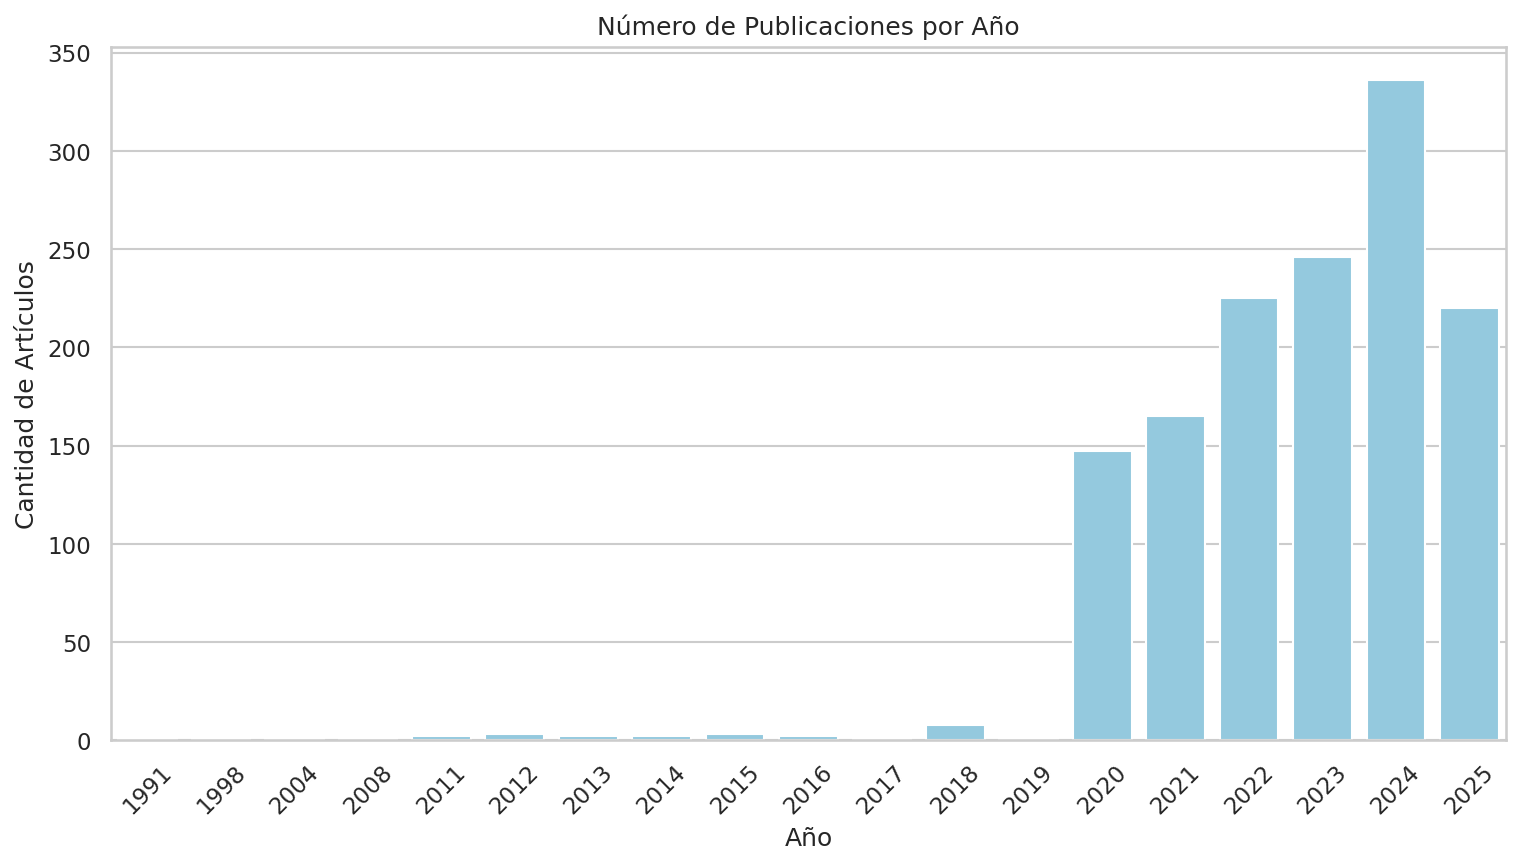

In [39]:
# Contar publicaciones por año
publications_per_year = df['year'].value_counts().sort_index()

# Visualizar
plt.figure(figsize=(12, 6))
sns.barplot(x=publications_per_year.index, y=publications_per_year.values, color='skyblue')
plt.title('Número de Publicaciones por Año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Artículos')
plt.xticks(rotation=45)
plt.show()

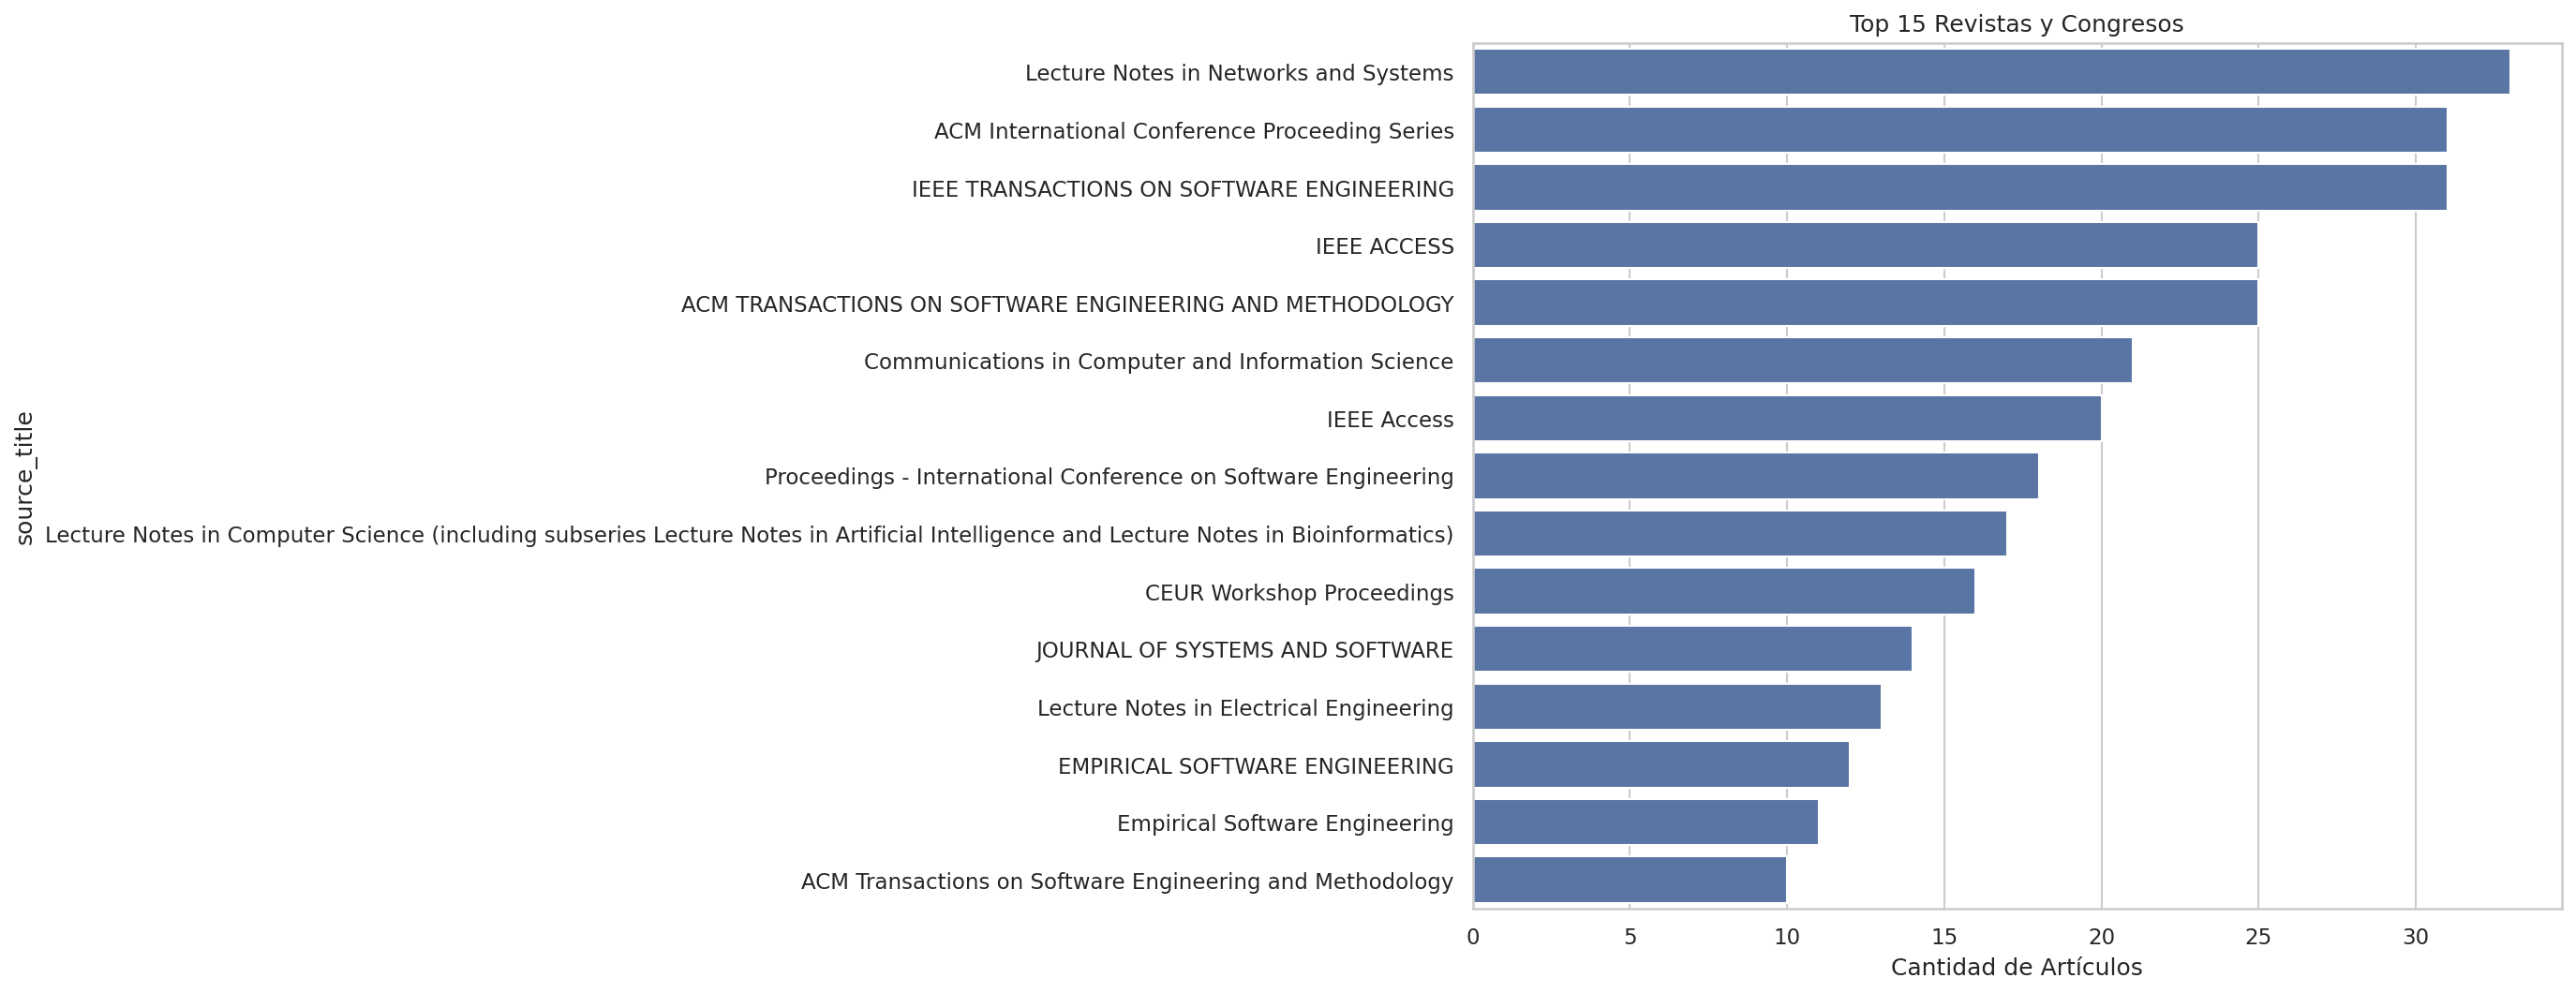

In [40]:
# Contar las 15 fuentes más comunes
top_sources = df['source_title'].value_counts().nlargest(15)

# Visualizar
plt.figure(figsize=(10, 8))
sns.barplot(x=top_sources.values, y=top_sources.index, orient='h')
plt.title('Top 15 Revistas y Congresos')
plt.xlabel('Cantidad de Artículos')
plt.show()

In [41]:
# La columna 'authors' suele ser un string separado por punto y coma o comas
# Creamos una lista de todos los autores
all_authors = df['authors'].str.split(';').explode()
all_authors = all_authors.str.strip() # Limpiar espacios en blanco

# Contar los 15 autores más frecuentes
top_authors = all_authors.value_counts().nlargest(15)
print("Top 15 Autores Más Prolíficos:")
print(top_authors)

Top 15 Autores Más Prolíficos:
authors
                 126
Liu Y.            16
Zhang Y.          13
Li Y.             12
Ricca F.           9
Wang J.            8
Kharmoum N.        8
Li Z.              8
Wang Y.            7
Khomh, Foutse      7
Chen J.            7
Wang H.            7
Zhang X.           7
Wang L.            7
Li J.              6
Name: count, dtype: int64


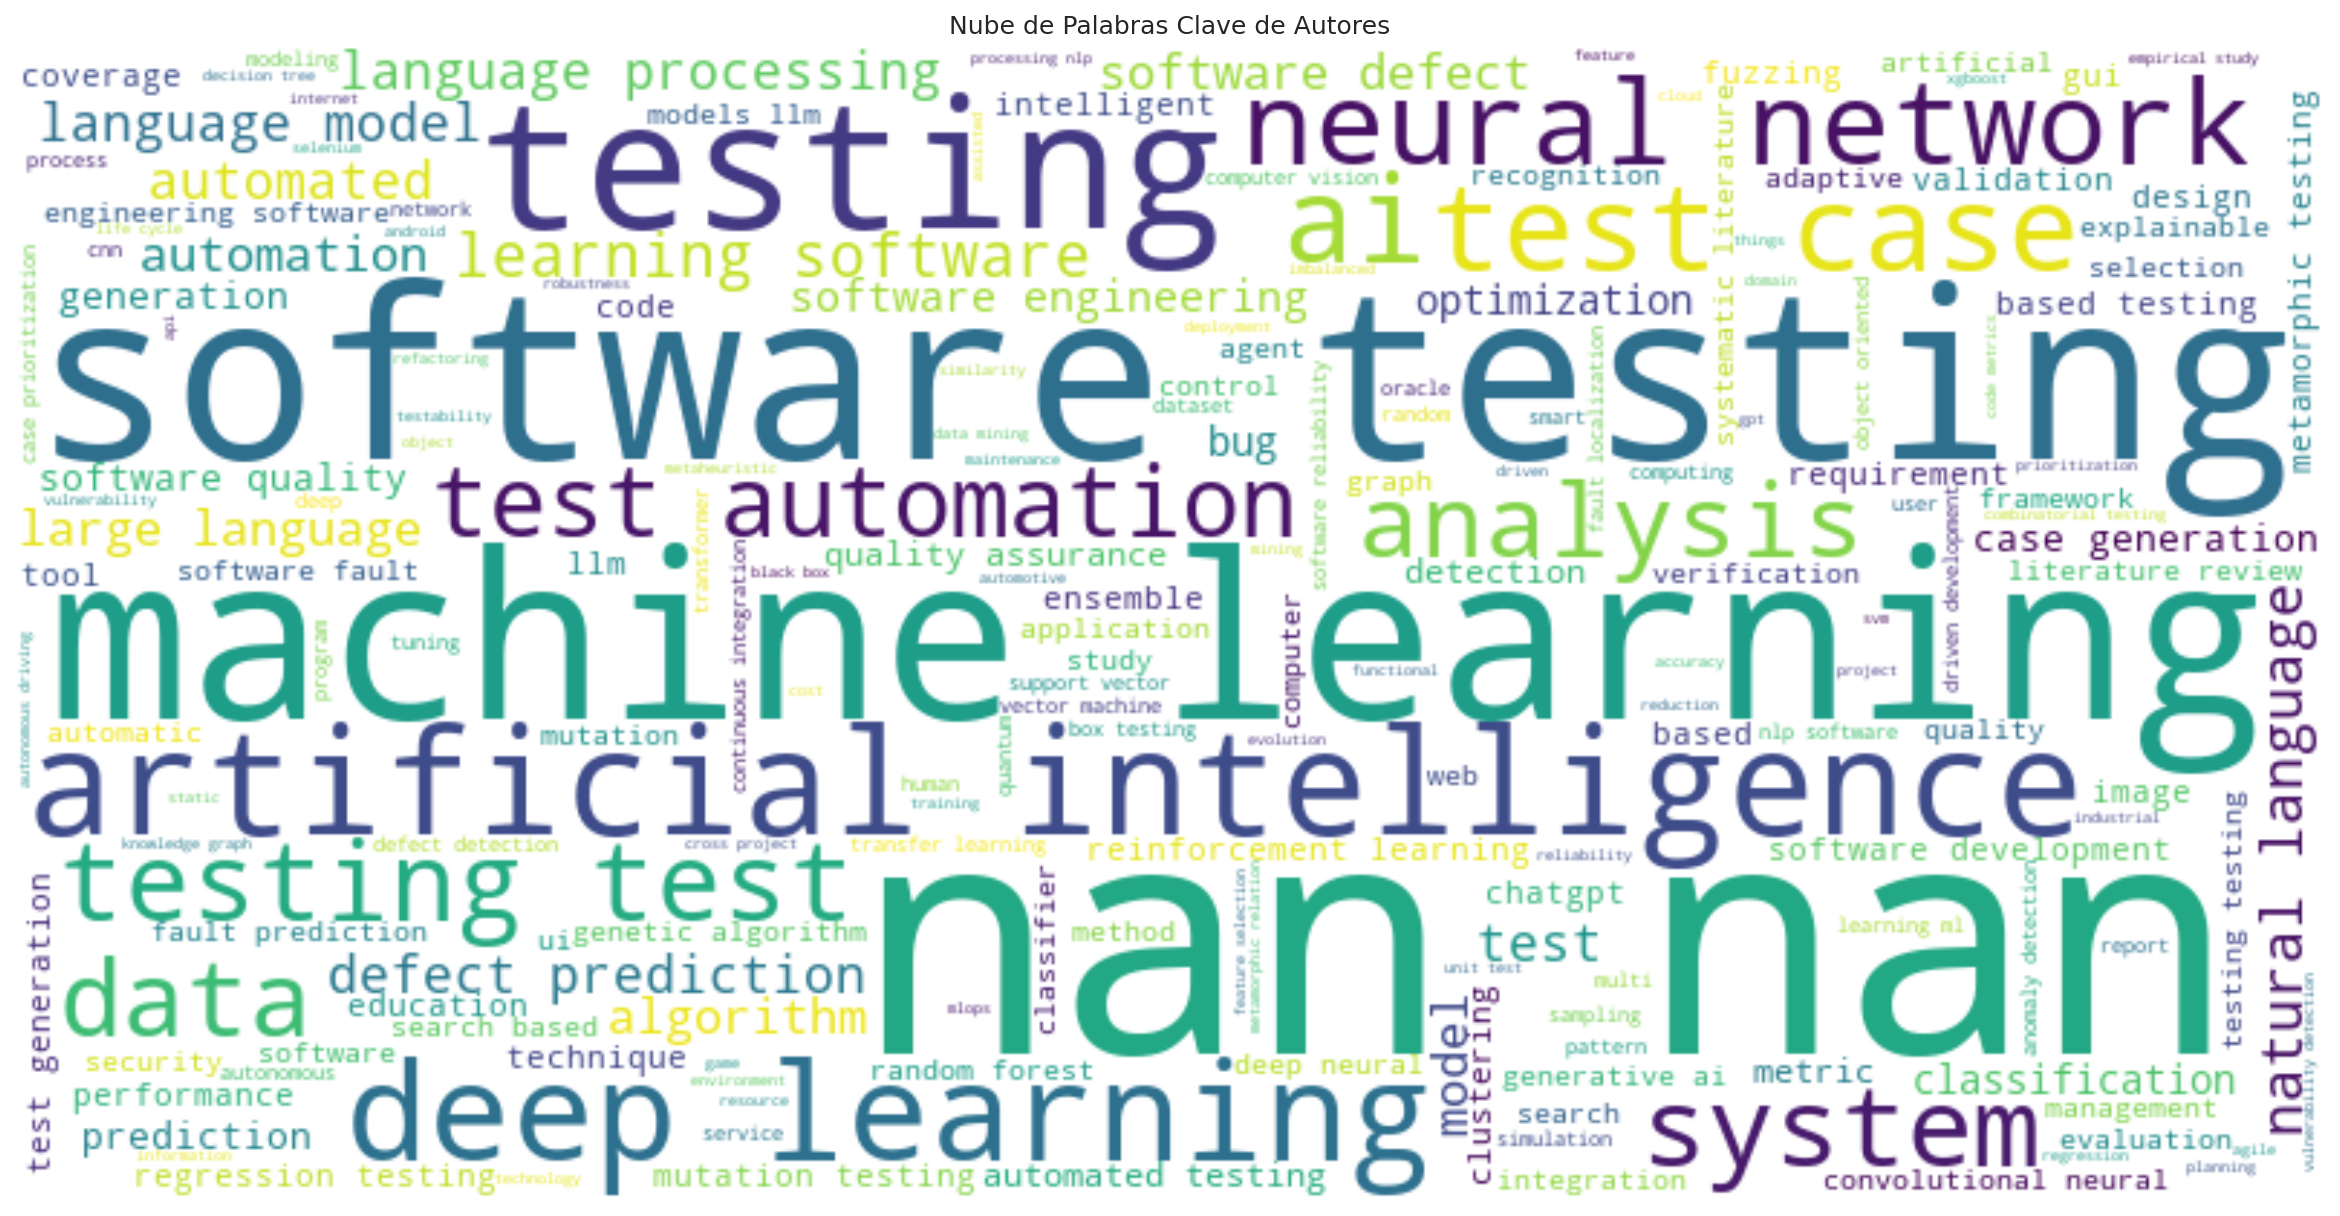

In [42]:
# Procesar la columna de palabras clave
all_keywords = df['author_Keywords'].str.split(';').explode()
all_keywords = all_keywords.str.strip().str.lower() # Normalizar

# Generar nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_keywords.dropna()))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Clave de Autores')
plt.show()

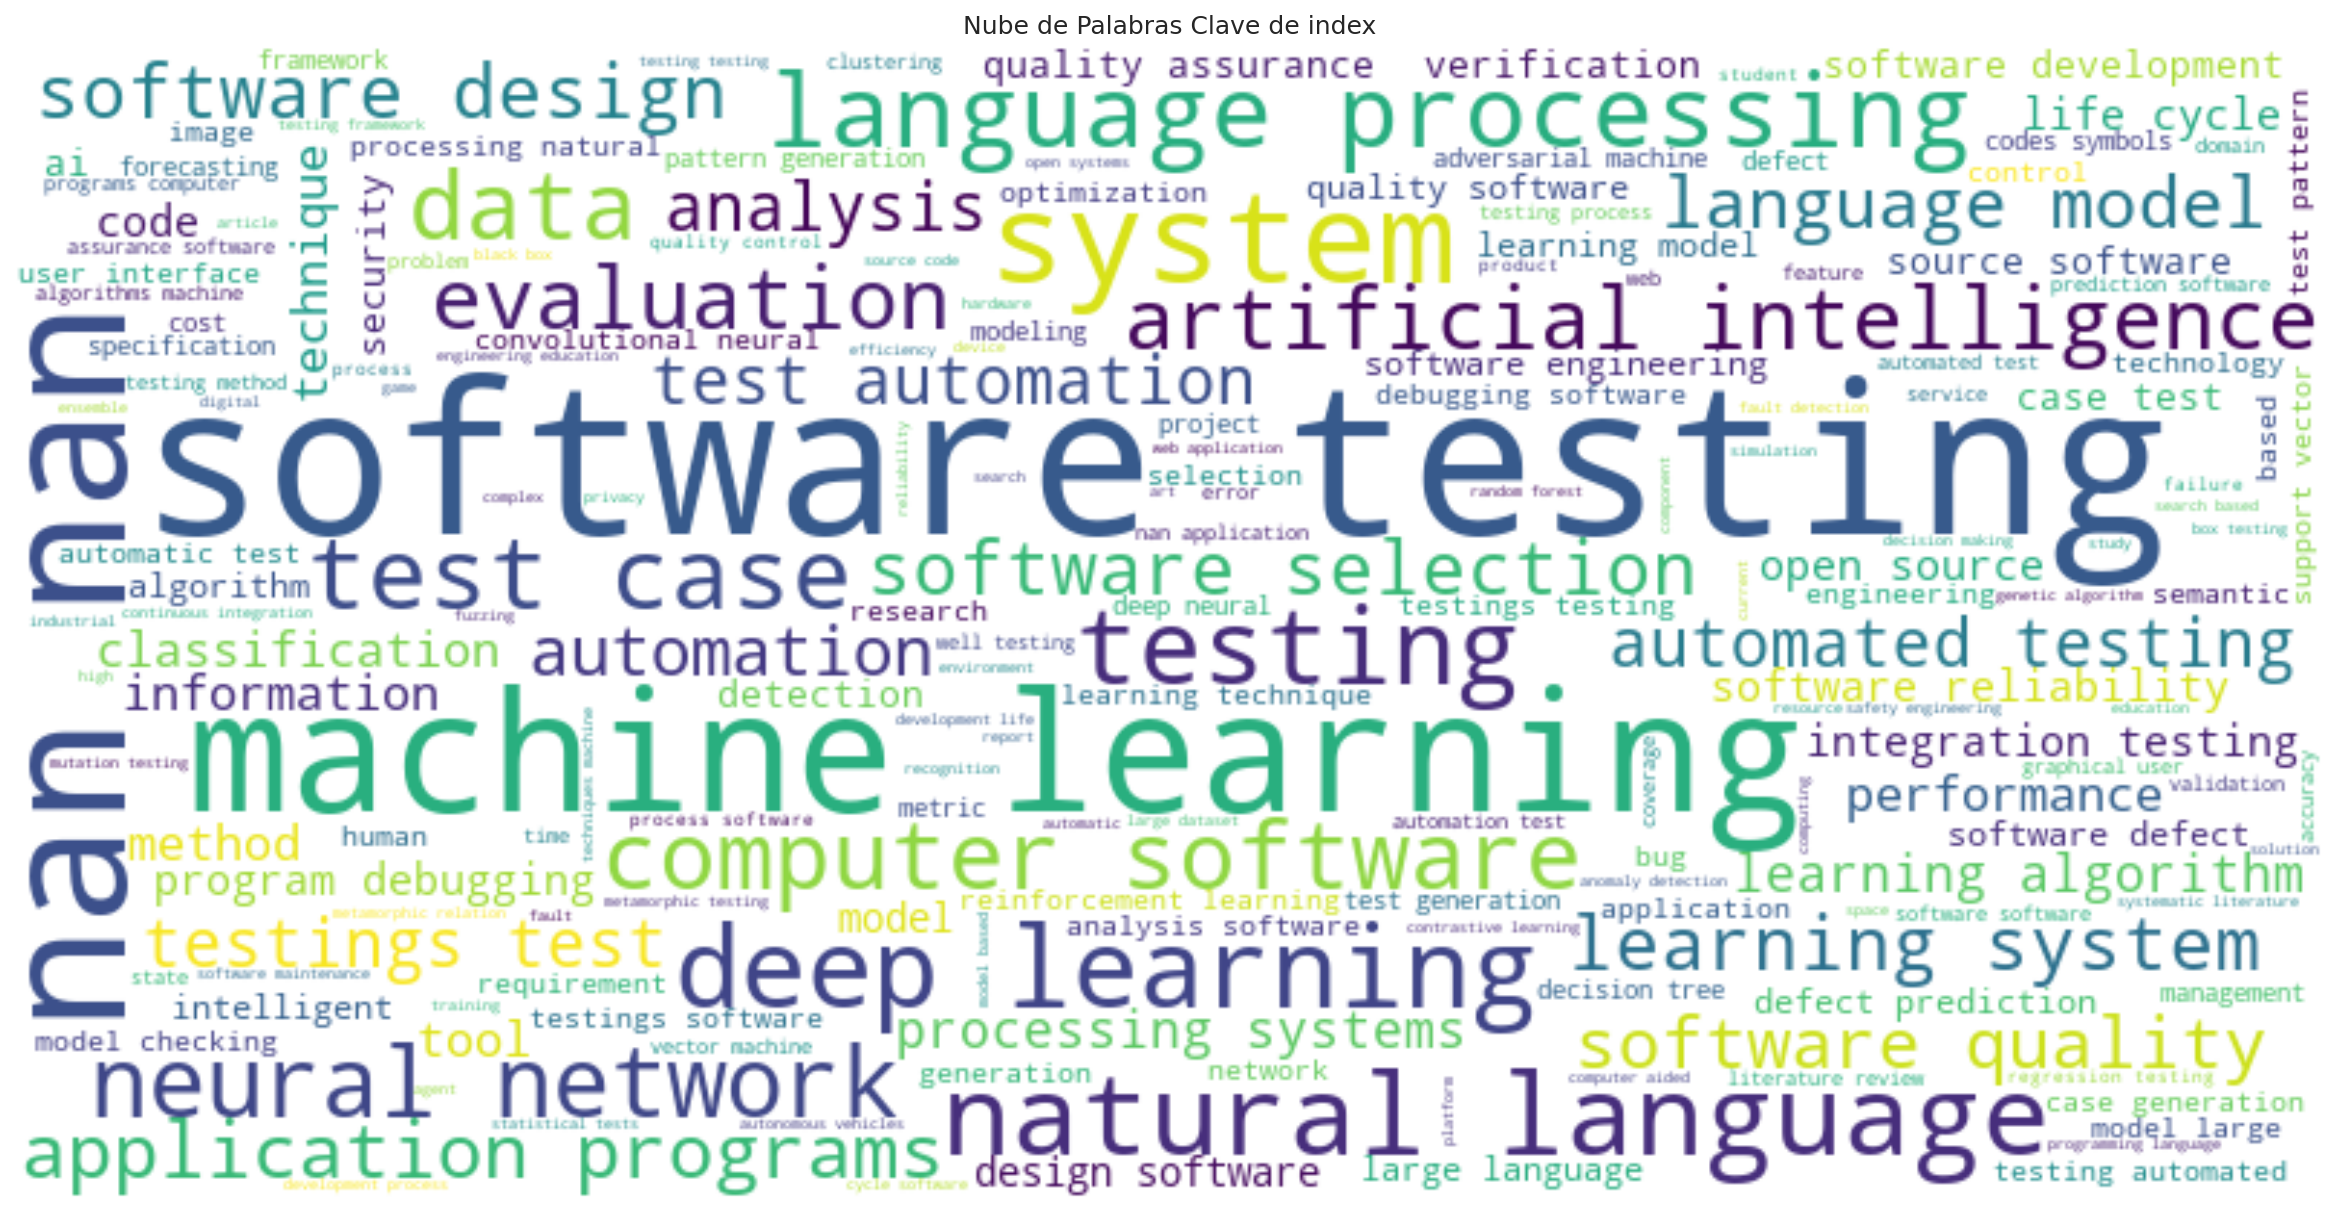

In [43]:
# Procesar la columna de palabras clave
all_keywords = df['index_keywords'].str.split(';').explode()
all_keywords = all_keywords.str.strip().str.lower() # Normalizar

# Generar nube de palabras
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_keywords.dropna()))

plt.figure(figsize=(20, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Nube de Palabras Clave de index')
plt.show()

In [44]:
# Combinar títulos y resúmenes en un solo texto por documento
df['text_for_analysis'] = df['title'] + ' ' + df['abstract']
# Limpiar el texto: minúsculas y quitar no alfanuméricos
df['text_for_analysis'] = df['text_for_analysis'].str.lower().apply(lambda x: re.sub(r'[^a-z\s]', '', x))

In [45]:
# --- Encontrar Bigramas (pares de palabras) más comunes ---
vectorizer_bigram = CountVectorizer(ngram_range=(2, 2), stop_words=list(stop_words))
X_bigram = vectorizer_bigram.fit_transform(df['text_for_analysis'])
bigram_counts = pd.DataFrame({
    'bigram': vectorizer_bigram.get_feature_names_out(),
    'count': X_bigram.toarray().sum(axis=0)
}).sort_values('count', ascending=False).head(20)

In [46]:
print("Top 20 Bigramas Más Comunes:")
print(bigram_counts)

Top 20 Bigramas Más Comunes:
                         bigram  count
99416          software testing   1370
63341          machine learning    918
107847               test cases    619
8835    artificial intelligence    427
27657             deep learning    397
107846                test case    391
99036      software development    332
10383         automated testing    312
99058      software engineering    271
27818         defect prediction    244
70696          natural language    233
107832          test automation    205
99017           software defect    198
99313          software quality    172
60928       learning techniques    148
59779            large language    147
71637            neural network    146
59651           language models    143
15193           case generation    141
91659              results show    140


In [47]:
# Usaremos la columna 'text_for_analysis' que creamos antes
# (título + resumen, en minúsculas y sin stopwords)

# Vectorizador: Ignora palabras que aparecen en más del 95% de los docs
# o en menos de 2 documentos. Esto elimina ruido.
vectorizer = CountVectorizer(max_df=0.95, min_df=2, stop_words=list(stop_words))

# Aplica el vectorizador para crear la matriz de frecuencias de palabras
X = vectorizer.fit_transform(df['text_for_analysis'])

In [48]:
# Define el número de tópicos que quieres encontrar (esto es un hiperparámetro clave)
num_topics = 10 # Empezamos con 10 como una suposición educada

# Crea y entrena el modelo LDA
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

LatentDirichletAllocation(random_state=42)

In [49]:
# Función para mostrar los tópicos
def display_topics(model, feature_names, num_top_words):
    for topic_idx, topic in enumerate(model.components_):
        # Imprime el número del tópico y las palabras más representativas
        print(f"Tópico #{topic_idx+1}:")
        message = " ".join([feature_names[i]
                            for i in topic.argsort()[:-num_top_words - 1:-1]])
        print(message)
        print("-" * 50)

# Obtiene los nombres de las palabras (las columnas de nuestra matriz)
feature_names = vectorizer.get_feature_names_out()
num_top_words = 10

# Muestra los tópicos
display_topics(lda, feature_names, num_top_words)

Tópico #1:
testing dl deep coverage fairness dnn software data learning criteria
--------------------------------------------------
Tópico #2:
software testing research ai ml engineering systems techniques development requirements
--------------------------------------------------
Tópico #3:
localization nan fault software program learning testing rnn automated actionable
--------------------------------------------------
Tópico #4:
software testing prediction learning machine defect performance models techniques using
--------------------------------------------------
Tópico #5:
testing software research human skills study automation learning new llms
--------------------------------------------------
Tópico #6:
test testing code models systems generation cases language method software
--------------------------------------------------
Tópico #7:
data ai automated testing learning system model research project systems
--------------------------------------------------
Tópico #8:
test 

In [50]:
# Generar la visualización
# Nota: es mejor hacerlo en un entorno como Jupyter Notebook para verla
pyLDAvis.enable_notebook()
panel = pyLDAvis.lda_model.prepare(lda, X, vectorizer, mds='tsne')

# Mostrar el panel interactivo
panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
8      -32.667381  -73.979042       1        1  19.255785
3       50.344315  110.000114       2        1  17.929256
5      -28.465054  117.439156       3        1  16.097190
9       46.296848  -81.362938       4        1  12.892307
7      100.777634  -23.652460       5        1  11.365359
1       20.073772  -12.816994       6        1   7.769951
6       -3.178363   48.412579       7        1   6.860669
0       77.473930   43.907391       8        1   3.816651
4      -83.396523   60.058632       9        1   2.731565
2      -61.021347   -8.067788      10        1   1.281265, topic_info=                Term         Freq        Total Category  logprob  loglift
5624        software  4092.000000  4092.000000  Default  30.0000  30.0000
6068            test  2908.000000  2908.000000  Default  29.0000  29.0000
197               ai   859.000000   859.000000  Default  28.0000  28.0000
4568      prediction   643.000000   643.000000  Default  27.0000  27.0000
6082         testing  3963.000000  3963.000000  Default  26.0000  26.0000
...              ...          ...          ...      ...      ...      ...
6465           using     7.333357  1080.614702  Topic10  -5.7317  -0.6355
3772         methods     6.897251   618.099417  Topic10  -5.7930  -0.1382
2921  identification     6.198033    86.835463  Topic10  -5.8999   1.7175
5154         results     6.585894   743.311875  Topic10  -5.8392  -0.3689
6174           tools     6.349656   359.474374  Topic10  -5.8758   0.3211

[789 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
49        1  0.897468  accounting
54        1  0.133790    accuracy
54        2  0.447588    accuracy
54        3  0.107032    accuracy
54        4  0.034056    accuracy
...     ...       ...         ...
6705      2  0.070078      worthy
6705      4  0.735822      worthy
6705      7  0.105117      worthy
6705      9  0.070078      worthy
6718      2  0.984940     xgboost

[2181 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 6, 10, 8, 2, 7, 1, 5, 3])